# RAM bandwidth, 1467MHz RAM & 1600MHz RAM, all I/O-die P-states

## Load necessary depencencies

In [1]:
import numpy
import csv
import re
import os
import matplotlib.pyplot as plt
import matplotlib
from pylab import rcParams

## Define functions

In [2]:
# taken from https://github.com/kloopuk/log-progress

# MIT License
#
# Copyright (c) 2016 bureaucratic-labs
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
# generate lists of files with files according to search parameters
def listgenerator (filelist, startstring, searchpara, retlist):

    searchpara = searchpara + "\""
    
    for file in filelist:
        for line in open(file):
            if line.startswith(startstring):
                if searchpara in line:
                    retlist.append(file)

In [4]:
def evaluation(filelist, core, size, state):
    
    csvvalues = numpy.array([])
    datapoints = numpy.array([])
    evaluation_vals = numpy.array([])


    # use measurements for same core from run with core 1
    if core == "0":
        coreline = "BENCHIT_KERNEL_CPU_LIST=\"0,1\""
    else:
        coreline = "BENCHIT_KERNEL_CPU_LIST=\"0," + core + "\""

    case_found = False
    core_found = False
    data_found = False


    # iterate over lines in file
    for file in filelist:

        # empty arrays
        csvvalues = numpy.array([])
        datapoints = numpy.array([])

        case_found = False
        core_found = False
        data_found = False

        for line in open(file):
            if line.startswith('comment='):
                if not line.startswith('comment=\"Core frequency at 2500MHz\"'):
                    break
                
            if line.startswith('BENCHIT_KERNEL_USE_MODE=\"' + state):
                case_found = True
                    
            # check if file has data for core
            if line.startswith(coreline) and case_found:
                core_found = True
            # data begins after "beginofdata" string, only search for this when coreline has been found in file
            if line.startswith("beginofdata") and core_found:
                data_found = True

            # append data to values array, make sure that no strings are appended
            if data_found and not line.startswith("endofdata") and not line.startswith("beginofdata"):
                
                # data for core 0 is taken from file that contains data for cores 0,1
                # data for core 0 can be found in col. index 1, every other core in col. index 2
                if core == "0":
                    csvvalues = numpy.append(csvvalues, float(line.split()[3]))
                else:
                    csvvalues = numpy.append(csvvalues, float(line.split()[4]))

                # append data sizes
                datapoints = numpy.append(datapoints, str(line.split()[0]))

        # process data only when wanted data has been found in file
        if data_found:

            # find data size string in datapoints array
            index = numpy.where(datapoints == size)
            
            # save latency value for given data size and next 4 values to array
            for i in range(4):
                evaluation_vals = numpy.append(evaluation_vals, csvvalues[index[0] + i])
            #print(evaluation_vals)
    # calculate minimum & stdev
    minimum = min(evaluation_vals)
    maximum = max(evaluation_vals)
    median = numpy.median(evaluation_vals)
    stdevs = numpy.std(evaluation_vals)

    return(minimum, maximum, median, stdevs)

In [16]:
# plotter function
def plotter(minima, DRAM_freqs, p_states, unit, variant, machine):

    #rcParams["font.size"]="8.0"
    fig, ax = plt.subplots()
    im = ax.imshow(minima, cmap='coolwarm_r')
    
    # set title
    #ax.set_title('STREAM ' + function + ' RAM Bandwidth in [GB/s], on ' + machine + '\n')
    
    # setup for main axes
    DRAM_freqs = ["1.467", "1.6"]
    xlabels = numpy.array(DRAM_freqs)
    ylabels = numpy.array(p_states)
   
    x = numpy.arange(len(xlabels))
    y = numpy.arange(len(ylabels))
    
    ax.set_xlabel('DRAM Frequency [GHz]')
    ax.set_ylabel('I/O-die P-state')

    ax.set_xticks(x)
    ax.set_yticks(y)
    
    ax.set_xticklabels(xlabels, rotation=0, ha='center', rotation_mode='anchor') 
    ax.set_yticklabels(ylabels, rotation=0, ha='right', rotation_mode='anchor') 
    
    # create colorbar
    cbarlabel = 'Latency [' + unit + ']'
    
    # define cbar ticks
    steps = 4
    
    cbarticks = []
    
    cbarticks.append(round(minima.min()+0.05,1))
    cbarticks.append(round(minima.max()-0.05,1))
    
    for i in range(1,steps):
        cbarticks.append(round(minima.min() + ((minima.max()-minima.min()) * float(i)/steps),1))
        
    cbarticks.sort()

    cbar = ax.figure.colorbar(im, shrink=1, pad=0.02, ticks=cbarticks)
    cbar.ax.set_ylabel(cbarlabel, rotation=+90, va="top")

    # secondary x-axis
    #def cyctons(x):
    #    return (x-0.5) * len(DRAM_freqs)
    
    #def nstocyc(x):
    #    return (x-0.5) / len(DRAM_freqs)
    
    # secondary x-axis
    #secax = ax.secondary_xaxis('top', functions =(nstocyc, cyctons)) 
    #secax.set_xticks(numpy.arange(len(p_states), step=1))
    #secax.set_xticklabels(p_states)
    #secax.set_xlabel('I/O-Die P-State')
    
    lc = 'white'
    lw = 3
    #ax.axvline(x=1.5, color=lc, linewidth=lw)
    #ax.axvline(x=3.5, color=lc, linewidth=lw)
    #ax.axvline(x=5.5, color=lc, linewidth=lw)
    #ax.axvline(x=7.5, color=lc, linewidth=lw)

    # set color for font depending on value
    thresholdLower = im.norm(minima.max())/3.
    thresholdUpper = im.norm(minima.max())/1.2
   
    textcolors=("white", "black")
    
    # Loop over data dimensions and create text annotations.
    for j in range(len(xlabels)):
        for i in range(len(ylabels)):
            if minima[i, j] > 100:
                value = int(round(minima[i, j]))
            else:
                value = int(round(minima[i, j]))

            text = ax.text(j, i, value,
                           ha="center", va="center", 
                           #size="small",
                           color=textcolors[int(im.norm(minima[i, j]) > 
                                                thresholdLower and im.norm(minima[i, j]) < 
                                                thresholdUpper)]) 
    
    # ensure proper layout
    fig.tight_layout()
        
    # save plot to file
    filename = '../../paper/fig/' + machine + '-DRAM_latency-all-p_states-' + variant + '.pdf'

    matplotlib.pyplot.savefig(filename, dpi=300, format='pdf', bbox_inches = 'tight', pad_inches = 0) 
    print(filename + ' has been saved to disk.')


## Create file lists

In [6]:
# get list of all files in directory

p_states = ['auto', '0', '1', '2', '3']
p_states.reverse()

filelist1467 = [],[],[],[],[]
filelist1600 = [],[],[],[],[]

for p_state in log_progress(p_states):
    p_index = p_states.index(p_state)
    path = 'io-P' + p_state + '/DRAM 1467MHz/datafiles'
    for entry in os.scandir(path): 
        filelist1467[p_index].append(entry.path)
        
    path = 'io-P' + p_state + '/DRAM 1600MHz/datafiles'
    for entry in os.scandir(path): 
        filelist1600[p_index].append(entry.path)
    print("Files for P-state " + p_state + ": " + str(len(filelist1600[p_index])))

Widget Javascript not detected.  It may not be installed or enabled properly.


Files for P-state 3: 1110
Files for P-state 2: 600
Files for P-state 1: 600
Files for P-state 0: 920
Files for P-state auto: 1347


## Process data

In [7]:
size = '3.06366e+07'

core = '0'

DRAM_freqs = ['1467', '1600']

minima = numpy.zeros([len(p_states), len(DRAM_freqs)])
maxima = numpy.zeros([len(p_states), len(DRAM_freqs)])
medians = numpy.zeros([len(p_states), len(DRAM_freqs)])
stdevs = numpy.zeros([len(p_states), len(DRAM_freqs)])

for p_state in log_progress(p_states):
    p_index = p_states.index(p_state)

    for DRAM_freq in DRAM_freqs:
        freq_index = DRAM_freqs.index(DRAM_freq)

        if DRAM_freq == '1467':
            state = 'I'
            filelist = filelist1467
        else:
            state = 'M'
            filelist = filelist1600

        minima[p_index][freq_index], \
        maxima[p_index][freq_index], \
        medians[p_index][freq_index], \
        stdevs[p_index][freq_index] = \
        evaluation(filelist[p_index], core, size, state)


Widget Javascript not detected.  It may not be installed or enabled properly.


## Plot Data

../../paper/fig/AMD EPYC 7502-DRAM_latency-all-p_states-minima.pdf has been saved to disk.
../../paper/fig/AMD EPYC 7502-DRAM_latency-all-p_states-maxima.pdf has been saved to disk.
../../paper/fig/AMD EPYC 7502-DRAM_latency-all-p_states-medians.pdf has been saved to disk.


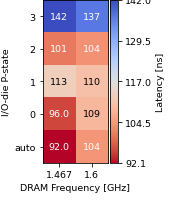

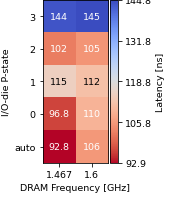

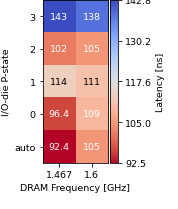

In [15]:
#rcParams['figure.figsize'] = 3, 4
rcParams['figure.figsize'] = 2.3, 3
#rcParams['figure.figsize'] = 2.625,3.5
rcParams['font.size'] = 9.5

plotter(minima, DRAM_freqs, p_states, 'ns', 'minima', 'AMD EPYC 7502')
plotter(maxima, DRAM_freqs, p_states, 'ns', 'maxima', 'AMD EPYC 7502')
plotter(medians, DRAM_freqs, p_states, 'ns', 'medians', 'AMD EPYC 7502')